In [20]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [21]:
def load_fold_data(experiment_dir, fold, epoch):
    """
    Generalized function to load fold data from a given experiment directory.

    Args:
        experiment_dir (str): The directory path where the experiment data is stored.
        num_folds (int): Number of folds (e.g., 3 for fold_0, fold_1, fold_2).
        epoch (int): Epoch number to be loaded (e.g., 0 for epoch_0).

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data of all folds with fold information.
    """
    file_path = os.path.join(
        experiment_dir, f"fold_{fold}_epoch_{epoch}_metrics.csv"
    )

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df["fold"] = fold
        return df
    else:
        print(f"Warning: File {file_path} does not exist.")

In [22]:
register_df = pd.read_csv("/net/scratch/cmosig/segmentation_meta/tiles_2025/register.csv")

In [23]:
experiment_dir = "/net/scratch/cmosig/experiment_dir_deadwood_segmentation/segformer_b5_new_metric/"

frames = []
for epoch in [0] + list(range(14, 105, 15)):
# for epoch in [0] + list(range(14, 200, 15)):
    for fold in [0,1,2]:
        frames.append(load_fold_data( experiment_dir, fold, epoch))

metrics_df = pd.concat(frames, ignore_index=True)
metrics_df

,tp,fp,fn,tn,precision,recall,f1,iou,accuracy,specificity,precision_0.5,recall_0.5,f1_0.5,iou_0.5,register_index,epoch,fold
0,0.0,399186.0,0.0,649390.0,0.000000,0.000000,0.000000,0.000000,0.619307,0.619307,0.000000,0.000000,0.000000,0.000000,8895,0,0
1,0.0,476296.0,0.0,572280.0,0.000000,0.000000,0.000000,0.000000,0.545769,0.545769,0.000000,0.000000,0.000000,0.000000,8896,0,0
2,1421.0,443929.0,178.0,603048.0,0.003191,0.888680,0.006359,0.003189,0.576467,0.575990,0.003191,0.888680,0.006359,0.003189,8897,0,0
3,0.0,508782.0,0.0,539794.0,0.000000,0.000000,0.000000,0.000000,0.514788,0.514788,0.000000,0.000000,0.000000,0.000000,8898,0,0
4,4434.0,363914.0,2639.0,677589.0,0.012038,0.626891,0.023621,0.011952,0.650428,0.650588,0.012038,0.626891,0.023621,0.011952,8899,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553115,16954.0,4231.0,578.0,1026813.0,0.800283,0.967032,0.875791,0.779029,0.995414,0.995896,0.800283,0.967032,0.875791,0.779029,377337,104,2
2553116,0.0,0.0,173.0,1047864.0,0.000000,0.000000,0.000000,0.000000,0.999835,1.000000,0.000000,0.000000,0.000000,0.000000,377338,104,2
2553117,4645.0,10087.0,3164.0,1030680.0,0.315300,0.594826,0.412138,0.259555,0.987363,0.990308,0.315300,0.594826,0.412138,0.259555,2342,104,2
2553118,1157.0,4915.0,106.0,1042398.0,0.190547,0.916073,0.315474,0.187277,0.995212,0.995307,0.190547,0.916073,0.315474,0.187277,2343,104,2


In [24]:
# thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# metrics_df = metrics_df[
#    (metrics_df[[f"precision_{t}" for t in thresholds]] != 0).any(axis=1)
#    & (metrics_df[[f"recall_{t}" for t in thresholds]] != 0).any(axis=1)
#    & (metrics_df[[f"f1_{t}" for t in thresholds]] != 0).any(axis=1)
#]
register_metrics = pd.merge(
    register_df, metrics_df, right_on="register_index", left_index=True
)
register_metrics.columns

Index(['base_file_name', 'file_path', 'global_file_path', 'resolution', 'x',
       'y', 'label_quality', 'mask_filled', 'resolution_bin', 'original',
       'biome', 'biome_group', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall',
       'f1', 'iou', 'accuracy', 'specificity', 'precision_0.5', 'recall_0.5',
       'f1_0.5', 'iou_0.5', 'register_index', 'epoch', 'fold'],
      dtype='object')

In [36]:
def get_prec_rec_f1(sdf):

    sdf = sdf.agg(
        { 
            "tp": "sum",
            "fp": "sum",
            "fn": "sum",
        }
    )

    precision = sdf["tp"] / (sdf["tp"] + sdf["fp"]) if (sdf["tp"] + sdf["fp"]) > 0 else 0
    recall = sdf["tp"] / (sdf["tp"] + sdf["fn"]) if (sdf["tp"] + sdf["fn"]) > 0 else 0
    f1 = (sdf["tp"] * 2) / (sdf["tp"] * 2 + sdf["fp"] + sdf["fn"]) if (sdf["tp"] * 2 + sdf["fp"] + sdf["fn"]) > 0 else 0

    return pd.Series({
        "precision_global": precision,
        "recall_global": recall,
        "f1_global": f1})

In [26]:
import matplotlib.colors as mcolors
import numpy as np

def create_green_colormap(steps=256):
    # Create color segments from white to dark green
    colors = [(1, 1, 1),          # White
             (0.8, 0.95, 0.8),    # Very light green
             (0.4, 0.8, 0.4),     # Light green
             (0, 0.6, 0),         # Medium green
             (0, 0.3, 0)]         # Dark green
    
    # Create colormap
    n_bins = steps
    green_cmap = mcolors.LinearSegmentedColormap.from_list(
        'custom_green', colors, N=n_bins)
    
    return green_cmap

/tmp/ipykernel_3741213/3204244662.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_metrics = register_metrics[register_metrics["fold"] == 0].groupby([spread, "biome_group", "epoch"]).apply(get_prec_rec_f1).reset_index()


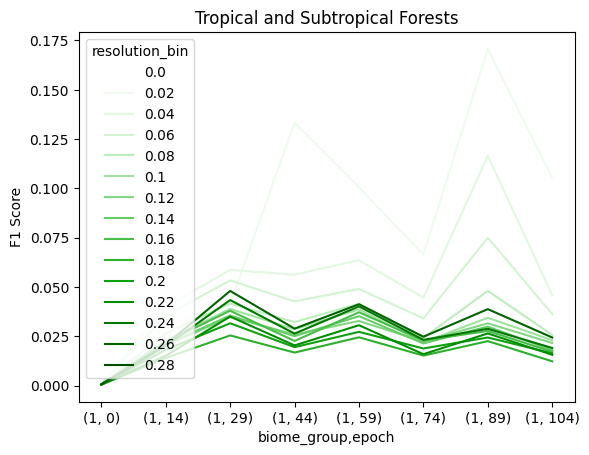

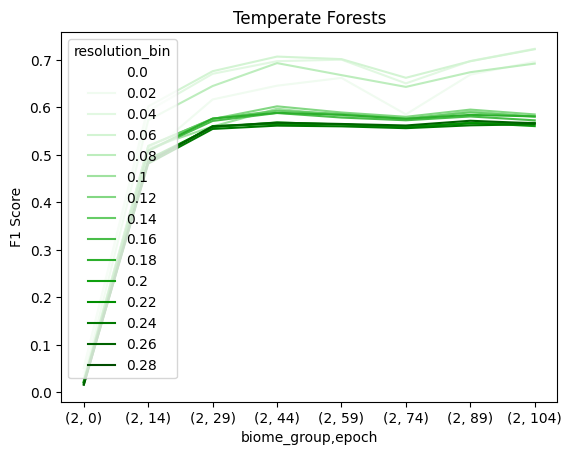

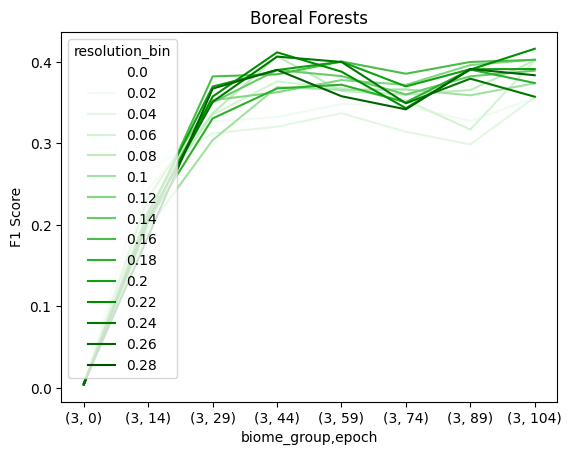

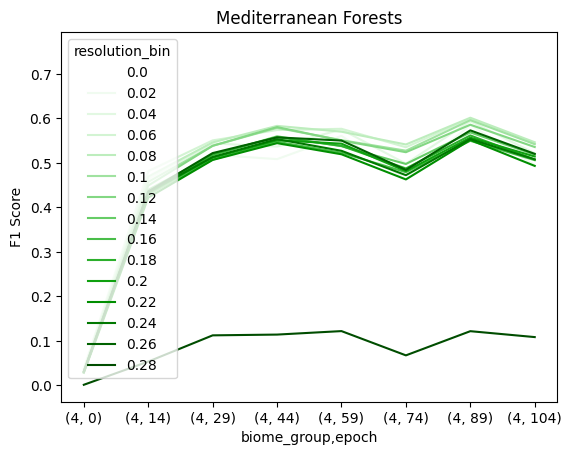

In [37]:
# sub_df = register_metrics[register_metrics["fold"] == 1]

BIOMEGROUPINGS = {
    "Tropical and Subtropical Forests": [1, 2, 3, 14, 7],
    "Temperate Forests": [4, 5, 8],
    "Boreal Forests": [6, 11, 10],
    "Mediterranean Forests": [12, 13, 9],
}

register_metrics["biome_res"] = register_metrics[["biome_group", "resolution_bin"]].apply(tuple, axis=1)

spread = "resolution_bin" 

# mean_metrics = register_metrics[register_metrics["fold"] == 0].groupby([spread, "biome_group", "epoch"]).agg({"f1_global": "mean", "recall_0.5": "mean", "precision_0.5": "mean"}).reset_index()

mean_metrics = register_metrics[register_metrics["fold"] == 0].groupby([spread, "biome_group", "epoch"]).apply(get_prec_rec_f1).reset_index()

mean_metrics_pivot = mean_metrics.pivot(columns=spread, index=["biome_group", "epoch"], values="f1_global")
axes = mean_metrics_pivot.groupby(["biome_group"]).plot(colormap=create_green_colormap(steps=15))

for i, ax in enumerate(axes):
    ax.set_ylabel("F1 Score")
    ax.set_title(list(BIOMEGROUPINGS.keys())[i])

/tmp/ipykernel_3741213/2923593371.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_metrics = register_metrics.groupby(["fold", spread, "biome_group", "epoch"]).apply(get_prec_rec_f1).reset_index()


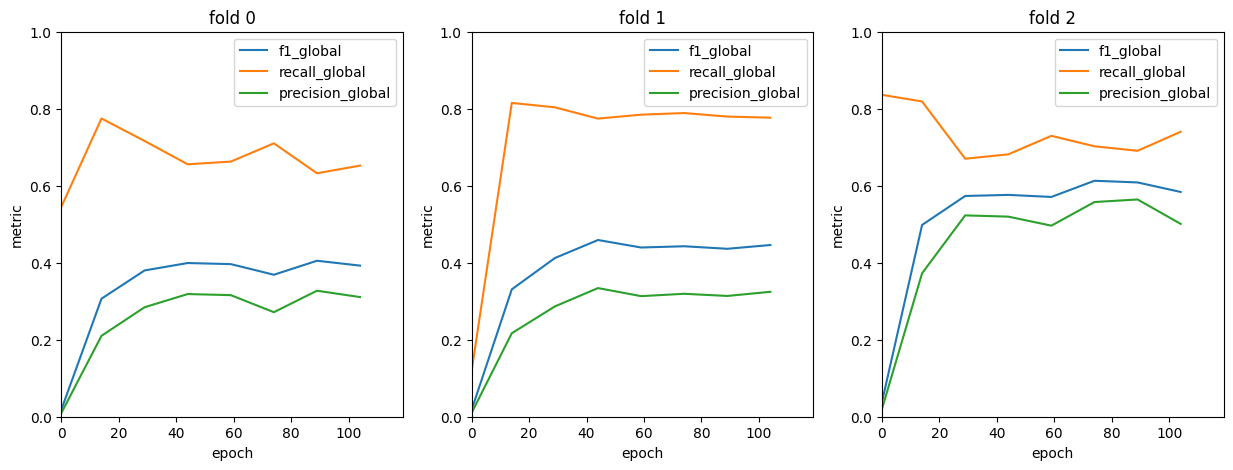

In [29]:
# mean_metrics = register_metrics.groupby(["fold", spread, "biome_group", "epoch"]).agg({"f1_global": "mean", "recall_0.5": "mean", "precision_0.5": "mean"}).reset_index()

mean_metrics = register_metrics.groupby(["fold", spread, "biome_group", "epoch"]).apply(get_prec_rec_f1).reset_index()

fig, axes = plt.subplots(ncols=3, figsize=(15,5))

# mean_metrics = mean_metrics[mean_metrics["resolution_bin"] == 0.02]

for i, (key, group) in enumerate(mean_metrics.groupby("fold")):
    axes[i].set_ylim((0,1))
    axes[i].set_xlim((0,119))
    axes[i].set_title("fold " + str(key))
    axes[i].set_ylabel("metric")
    group.groupby(["epoch"])[["f1_global","recall_global","precision_global"]].mean().plot(ax=axes[i])

Text(0, 0.5, 'metric')

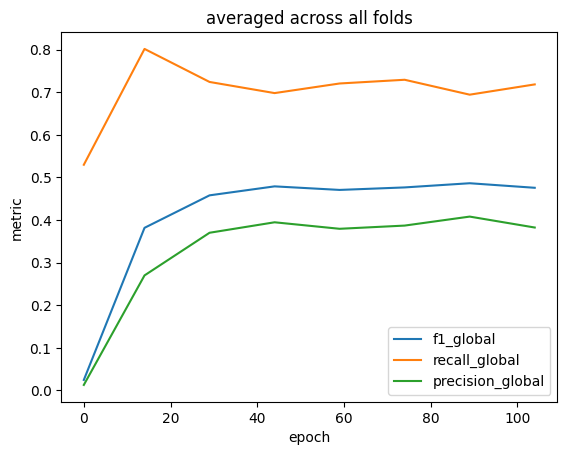

In [30]:
ax = mean_metrics.groupby(["epoch"])[["f1_global","recall_global","precision_global"]].mean().plot()
ax.set_title("averaged across all folds")
ax.set_ylabel("metric")

In [66]:
BIOMEGROUPINGS = {
    "(Sub) Tropical": [1, 2, 3, 14, 7],
    "Temperate": [4, 5, 8],
    "Boreal and Montane": [6, 11, 10],
    "Drylands": [12, 13, 9],
}

BIOMEGROUPINGS_INDEX_NAME = dict(zip(range(1, len(BIOMEGROUPINGS.keys()) + 1), BIOMEGROUPINGS.keys()))
BIOMEGROUPINGS_INDEX_NAME

optimal_resolution_biome = {
    1: 0.04, 
    2: 0.04,
    3: 0.00, 
    4: 0.06, 
}

# only take epoch 104
register_metrics_filtered = register_metrics[register_metrics["epoch"] == 104].copy()

# only take optimal resolution bin
register_metrics_filtered = register_metrics_filtered.groupby("biome_group").apply( lambda x: x[x["resolution_bin"] == optimal_resolution_biome[x["biome_group"].iloc[0]]]).reset_index(drop=True)

print(register_metrics["biome_group"].value_counts())
print(register_metrics_filtered["biome_group"].value_counts())

biome_table = register_metrics_filtered.groupby(["biome_group"]).apply(get_prec_rec_f1).reset_index()

biome_table = biome_table.rename(columns={"biome_group":"Biome Group"}).set_index("Biome Group")

biome_table.index = biome_table.index.map(BIOMEGROUPINGS_INDEX_NAME)

biome_table = biome_table.rename(columns={
    "precision_global": "Precision",
    "recall_global": "Recall",
    "f1_global": "F1",
})

biome_table = biome_table[["F1", "Precision", "Recall"]]

biome_table = biome_table.round(2)
biome_table["F1"] = biome_table["F1"].astype(str)
biome_table["Precision"] = biome_table["Precision"].astype(str)
biome_table["Recall"] = biome_table["Recall"].astype(str)

print(biome_table.to_latex())

biome_group
2    2094944
4     276712
1     166024
3      15440
Name: count, dtype: int64
biome_group
2    26004
1     4772
4     3413
3      678
Name: count, dtype: int64
\begin{tabular}{llll}
\toprule
 & F1 & Precision & Recall \\
Biome Group &  &  &  \\
\midrule
(Sub) Tropical & 0.5 & 0.4 & 0.69 \\
Temperate & 0.71 & 0.59 & 0.9 \\
Boreal and Montane & 0.6 & 0.48 & 0.81 \\
Drylands & 0.6 & 0.47 & 0.83 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3741213/3921927478.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  register_metrics_filtered = register_metrics_filtered.groupby("biome_group").apply( lambda x: x[x["resolution_bin"] == optimal_resolution_biome[x["biome_group"].iloc[0]]]).reset_index(drop=True)
/tmp/ipykernel_3741213/3921927478.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  biome_table = register_metrics_filtered.g

In [67]:
biome_table

,F1,Precision,Recall
Biome Group,,,
(Sub) Tropical,0.5,0.4,0.69
Temperate,0.71,0.59,0.9
Boreal and Montane,0.6,0.48,0.81
Drylands,0.6,0.47,0.83


In [20]:
biome_table

,F1,Recall,Precision
Biome Group,,,
(Sub) Tropical,0.31,0.67,0.26
Temperate,0.71,0.87,0.61
Boreal and Montane,0.32,0.43,0.26
Drylands,0.57,0.8,0.45
